In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from scripts.insar_conversion import convert_insar_to_u
import numpy as np
from scipy.optimize import curve_fit

### Import mining region

In [2]:
# --- Read shapefile ---
shp_area = r"maps\concessions_SL\Concessions_SL_area_v1.shp"
gdf_area = gpd.read_file(shp_area)

# Ensure shapefile is in lat/lon
gdf_area = gdf_area.to_crs(epsg=4326)

### Import GNSS

In [3]:
# --- Load ---
path = "gnss/gnss_data.csv"
df = pd.read_csv(path)

# --- Parse + clean ---
df["dates"] = pd.to_datetime(df["dates"], errors="coerce")
df = df.dropna(subset=["dates"])  # drop rows with bad dates

In [4]:
df.head()

,pnt_id,pnt_name,pnt_lat,pnt_lon,pnt_xrd,pnt_yrd,dates,n,e,u,sn,se,su
0,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2002-11-20,0.000426,0.007671,0.005879,0.000932,0.000673,0.002627
1,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-12,0.000447,-0.001009,-0.005334,0.000888,0.000654,0.002506
2,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-11,0.000381,0.000116,-0.005035,0.000889,0.000652,0.002511
3,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-10,0.000678,-0.001208,-0.006365,0.000893,0.000657,0.002522
4,0591,Aachen,50.767778,6.088333,204465.62255,308885.632138,2007-11-09,-0.000864,-0.002044,-0.009819,0.000904,0.000663,0.002558


### Import InSAR

In [5]:
loc_asc = r'insar/sentinel1_asc_t088_limburg.csv'
loc_dsc = r'insar/sentinel1_dsc_t037_limburg.csv'

insar_asc_LOS = pd.read_csv(loc_asc, sep=',')
insar_dsc_LOS = pd.read_csv(loc_dsc, sep=',')

In [6]:
insar_asc_u = convert_insar_to_u(insar_asc_LOS)
insar_dsc_u = convert_insar_to_u(insar_dsc_LOS)

In [7]:
# # Extract the dates from the .csv file
insar_dates = pd.to_datetime(insar_asc_u.filter(regex='^u_20').columns, format='u_%Y%m%d')

# # Extract the displacement data from the .csv file
disp_asc_u = insar_asc_u.filter(regex='^u_20')
disp_asc_d = insar_asc_LOS.filter(regex='^d_20')

# Calculate the nr of days between the observations where the first observations is day 0
days = (insar_dates - insar_dates[0]).days
years = days/365

### Plot all data

C:\Users\alami\AppData\Local\Temp\ipykernel_25332\2372800445.py:52: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


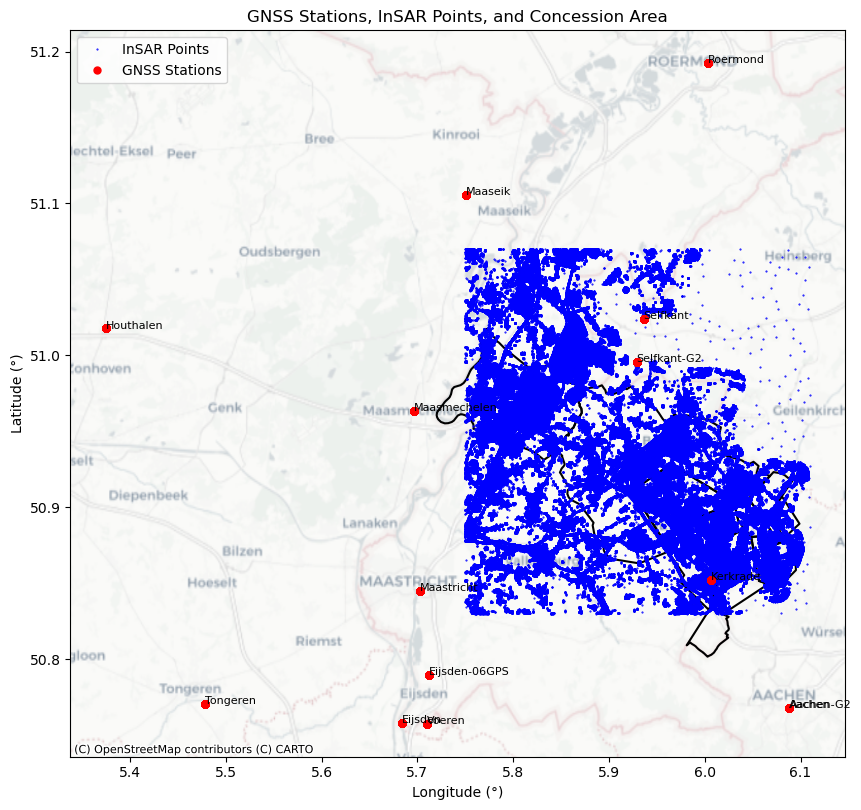

In [8]:
# --- Create figure ---
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot concession area ---
gdf_area.plot(
    ax=ax,
    edgecolor="black",
    facecolor="none",
    linewidth=1.5,
    zorder=2,
    label="Concession Area"
)

# --- Plot InSAR points ---
ax.plot(
    insar_asc_u.pnt_lon,
    insar_asc_u.pnt_lat,
    ".",
    color="blue",
    markersize=1,
    alpha=1,
    label="InSAR Points",
    zorder=3
)

# --- Plot GNSS stations ---
ax.plot(
    df["pnt_lon"],
    df["pnt_lat"],
    "o",
    color="red",
    markersize=5,
    label="GNSS Stations",
    zorder=4
)

# --- Add GNSS station labels ---
for name in df["pnt_name"].unique():
    subset = df[df["pnt_name"] == name]
    ax.text(
        subset["pnt_lon"].iloc[0],
        subset["pnt_lat"].iloc[0],
        name,
        fontsize=8,
        zorder=5
    )

# --- Labels & title ---
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("GNSS Stations, InSAR Points, and Concession Area")
ax.legend()

# station_name = "Kerkrade"
# buffer = 0.001

# st = df.loc[df["pnt_name"] == station_name].iloc[0]
# x0, y0 = st["pnt_lon"], st["pnt_lat"]

# xmin, xmax = x0 - buffer, x0 + buffer
# ymin, ymax = y0 - buffer, y0 + buffer

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)


#label only stations inside current view
# df_view = df[(df["pnt_lon"].between(xmin, xmax)) & (df["pnt_lat"].between(ymin, ymax))]

# for name in df_view["pnt_name"].unique():
#     s = df_view[df_view["pnt_name"] == name].iloc[0]
#     ax.text(s["pnt_lon"], s["pnt_lat"], name, fontsize=8, zorder=10, clip_on=True)

#--- Add basemap (NO API KEY REQUIRED) ---
ctx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron,
    zoom=10
)

plt.show()


C:\Users\alami\AppData\Local\Temp\ipykernel_25332\2784325883.py:52: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


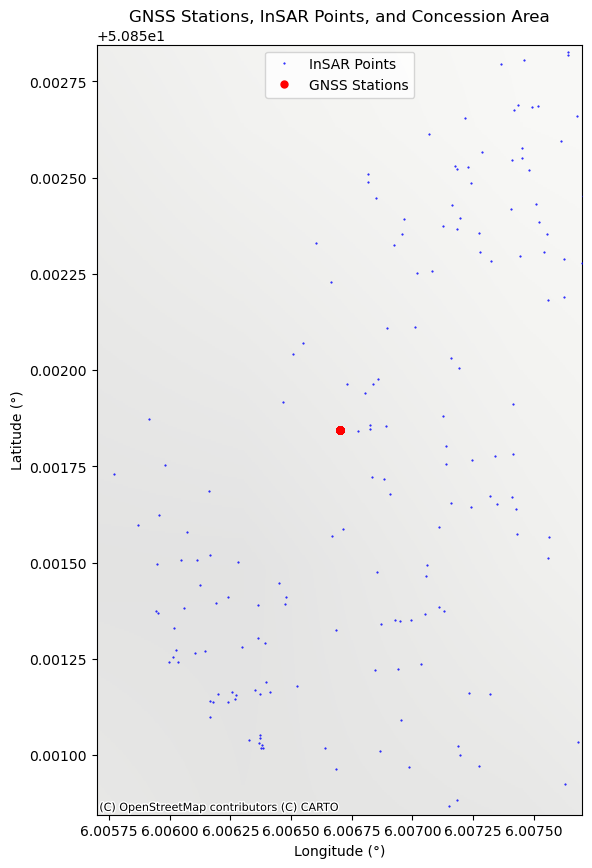

In [9]:
# --- Create figure ---
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot concession area ---
gdf_area.plot(
    ax=ax,
    edgecolor="black",
    facecolor="none",
    linewidth=1.5,
    zorder=2,
    label="Concession Area"
)

# --- Plot InSAR points ---
ax.plot(
    insar_asc_u.pnt_lon,
    insar_asc_u.pnt_lat,
    ".",
    color="blue",
    markersize=1,
    alpha=1,
    label="InSAR Points",
    zorder=3
)

# --- Plot GNSS stations ---
ax.plot(
    df["pnt_lon"],
    df["pnt_lat"],
    "o",
    color="red",
    markersize=5,
    label="GNSS Stations",
    zorder=4
)

# --- Add GNSS station labels ---
# for name in df["pnt_name"].unique():
#     subset = df[df["pnt_name"] == name]
#     ax.text(
#         subset["pnt_lon"].iloc[0],
#         subset["pnt_lat"].iloc[0],
#         name,
#         fontsize=8,
#         zorder=5
#     )

# --- Labels & title ---
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("GNSS Stations, InSAR Points, and Concession Area")
ax.legend()

station_name = "Kerkrade"
buffer = 0.001

st = df.loc[df["pnt_name"] == station_name].iloc[0]
x0, y0 = st["pnt_lon"], st["pnt_lat"]

xmin, xmax = x0 - buffer, x0 + buffer
ymin, ymax = y0 - buffer, y0 + buffer

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)


#label only stations inside current view
# df_view = df[(df["pnt_lon"].between(xmin, xmax)) & (df["pnt_lat"].between(ymin, ymax))]

# for name in df_view["pnt_name"].unique():
#     s = df_view[df_view["pnt_name"] == name].iloc[0]
#     ax.text(s["pnt_lon"], s["pnt_lat"], name, fontsize=8, zorder=10, clip_on=True)

#--- Add basemap (NO API KEY REQUIRED) ---
ctx.add_basemap(
    ax,
    crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron,
    zoom=10
)

plt.show()


In [10]:
def haversine_m(lat1, lon1, lat2, lon2):
    """
    Great-circle distance between (lat1, lon1) and (lat2, lon2) in meters.
    Inputs can be scalars or numpy arrays.
    """
    R = 6371000.0  # Earth radius [m]
    lat1 = np.deg2rad(lat1); lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2); lon2 = np.deg2rad(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def find_nearest_insar_points(insar_df, lat_0, lon_0, N=5,
                              lat_col="pnt_lat", lon_col="pnt_lon"):
    """
    Returns the N nearest InSAR points to (lat_0, lon_0) with distances in meters.
    """
    lat = insar_df[lat_col].to_numpy()
    lon = insar_df[lon_col].to_numpy()

    dist_m = haversine_m(lat_0, lon_0, lat, lon)
    nearest_idx = np.argsort(dist_m)[:N]

    out = insar_df.iloc[nearest_idx].copy()
    out["dist_m"] = dist_m[nearest_idx]
    return out.sort_values("dist_m")

In [11]:
station_name = 'Kerkrade'
lat_0 = df.loc[df['pnt_name'] == station_name, 'pnt_lat'].values[0]
lon_0 = df.loc[df['pnt_name'] == station_name, 'pnt_lon'].values[0]

print(f"{station_name} coordinates: lat={lat_0}, lon={lon_0}")


N = 8

# Use the DataFrame that still has metadata columns (pnt_lat/pnt_lon) + u_ columns.
# For example: insar_asc_u = add_vertical_insar(insar_asc) or convert_insar_to_u(insar_asc_LOS)
nearest = find_nearest_insar_points(insar_asc_u, lat_0, lon_0, N=N)

display(nearest[["pnt_id", "pnt_lat", "pnt_lon", "dist_m"]].head(N))

print(len(nearest))

Kerkrade coordinates: lat=50.851845, lon=6.0067


,pnt_id,pnt_lat,pnt_lon,dist_m
52106,L00012592P00029966,50.851842,6.006776,5.318895
52107,L00012592P00029967,50.851847,6.006823,8.672079
52105,L00012592P00029965,50.851858,6.006824,8.840901
52620,L00012593P00029967,50.851940,6.006803,12.815405
52619,L00012593P00029966,50.851964,6.006731,13.381351
52108,L00012592P00029968,50.851855,6.006892,13.487364
52622,L00012593P00029970,50.851965,6.006836,16.364168
51585,L00012591P00029966,50.851721,6.006835,16.684038


8


In [12]:
def plot_gnss_insar_locations(insar_df, nearest_df, lat_0, lon_0,
                              lat_col="pnt_lat", lon_col="pnt_lon"):
    """
    Plot GNSS location and nearest InSAR points in lon-lat space.
    """
    plt.figure(figsize=(6, 6))

    # Nearest InSAR points
    plt.scatter(
        nearest_df[lon_col],
        nearest_df[lat_col],
        s=80,
        c="tab:blue",
        marker="o",
        label="Nearest InSAR points"
    )

    # GNSS station
    plt.scatter(
        lon_0,
        lat_0,
        s=120,
        c="red",
        marker="*",
        label="GNSS station"
    )

    # Annotate distances (optional but useful)
    for _, row in nearest_df.iterrows():
        plt.text(
            row[lon_col],
            row[lat_col],
            f"{row['dist_m']:.0f} m",
            fontsize=8,
            ha="left",
            va="bottom"
        )

    plt.xlabel("Longitude [deg]")
    plt.ylabel("Latitude [deg]")
    plt.title("GNSS station and nearest InSAR points")
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


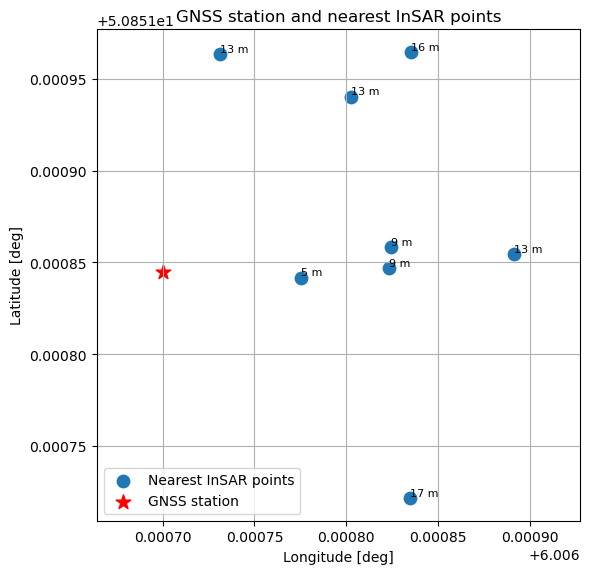

In [13]:
plot_gnss_insar_locations(
    insar_df=insar_asc_u,   # full InSAR DF with lat/lon
    nearest_df=nearest,     # output from find_nearest_insar_points
    lat_0=lat_0,
    lon_0=lon_0
)


In [14]:
# Extract displacement time series for nearest InSAR points
u_cols = insar_asc_u.filter(regex=r"^u_20").columns
disp_nearest_u = insar_asc_u.loc[nearest.index, u_cols]  # shape (N, n_times)

insar_mean_u = disp_nearest_u.mean(axis=0)  # Series indexed by u_YYYYMMDD columns
insar_mean_u = insar_mean_u.to_numpy()

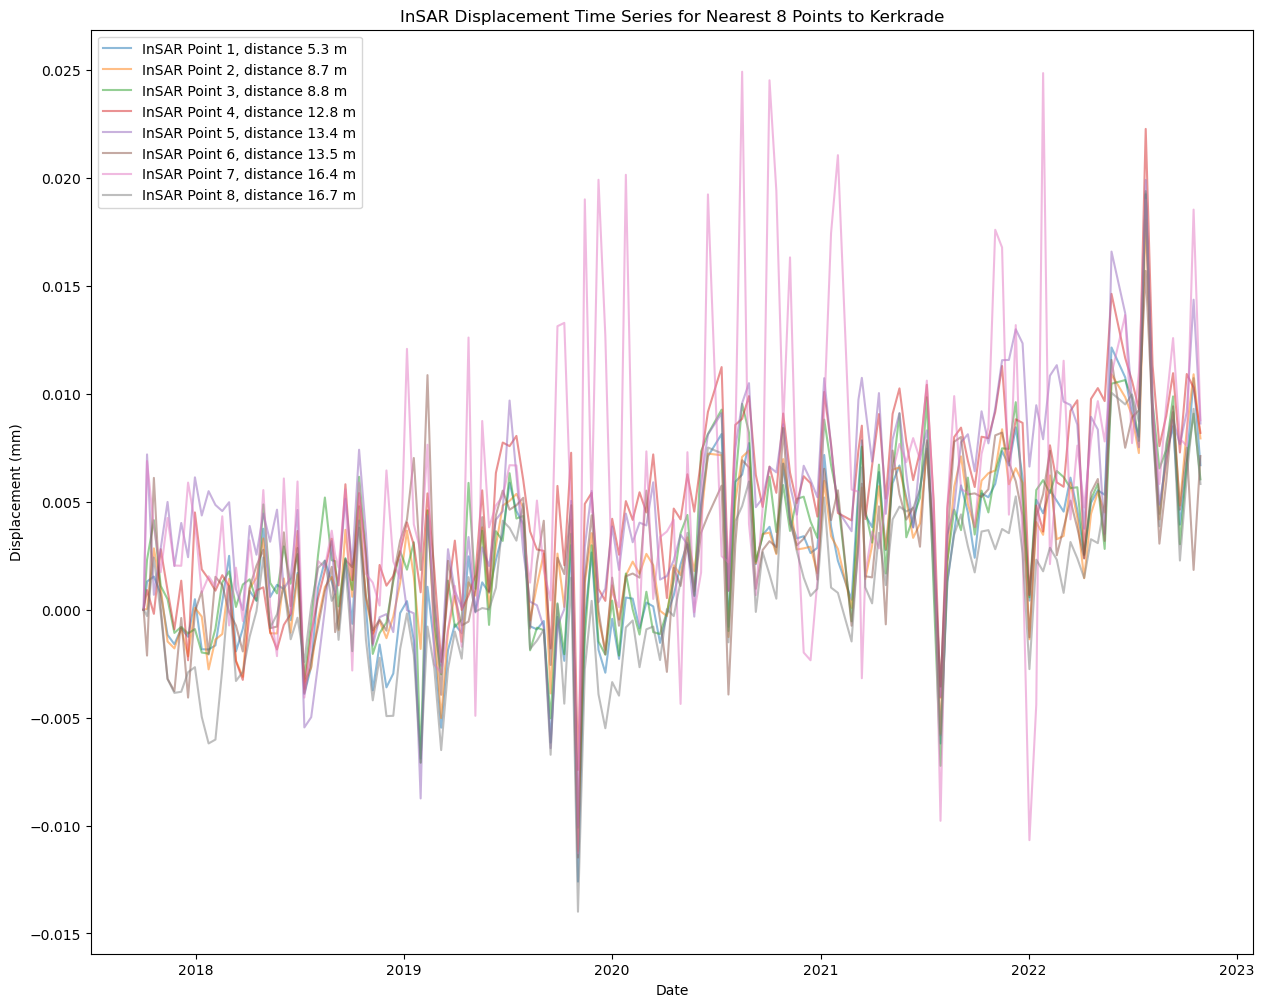

In [15]:
# Plot N nearest InSAR points and their mean
plt.figure(figsize=(15, 12))
for i in range(N):
    plt.plot(insar_dates, disp_nearest_u.iloc[i, :], label=f"InSAR Point {i+1}, distance {nearest.iloc[i]['dist_m']:.1f} m", alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Displacement (mm)")
plt.title(f"InSAR Displacement Time Series for Nearest {N} Points to {station_name}")
plt.legend()
plt.show()


C:\Users\alami\AppData\Local\Temp\ipykernel_25332\3587046566.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


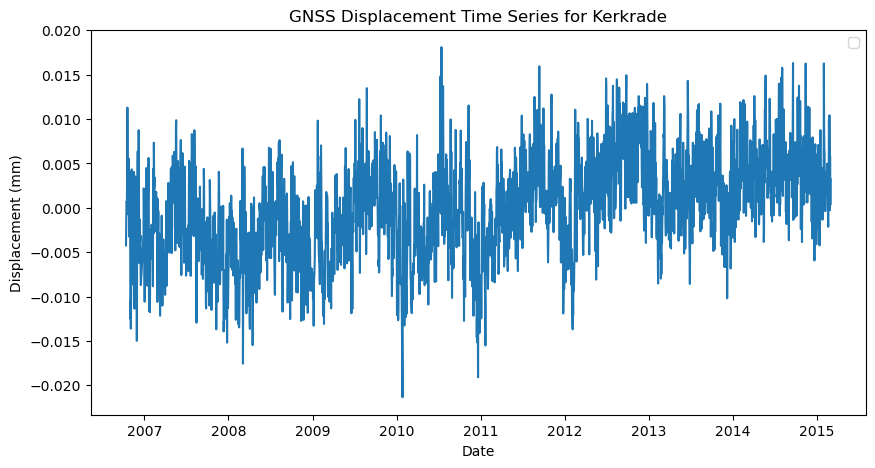

In [16]:
# Kerkrade time series

series_kerkrade = df[df["pnt_name"] == station_name].copy()
series_kerkrade_sorted = series_kerkrade.sort_values(by="dates")

gnss_dates = series_kerkrade_sorted["dates"]
gnss_u = series_kerkrade_sorted["u"].values

plt.figure(figsize=(10, 5))
plt.plot(gnss_dates, gnss_u)
plt.xlabel("Date")
plt.ylabel("Displacement (mm)")
plt.title(f"GNSS Displacement Time Series for {station_name}")
plt.legend()
plt.show()

# Combine with InSAR dataset

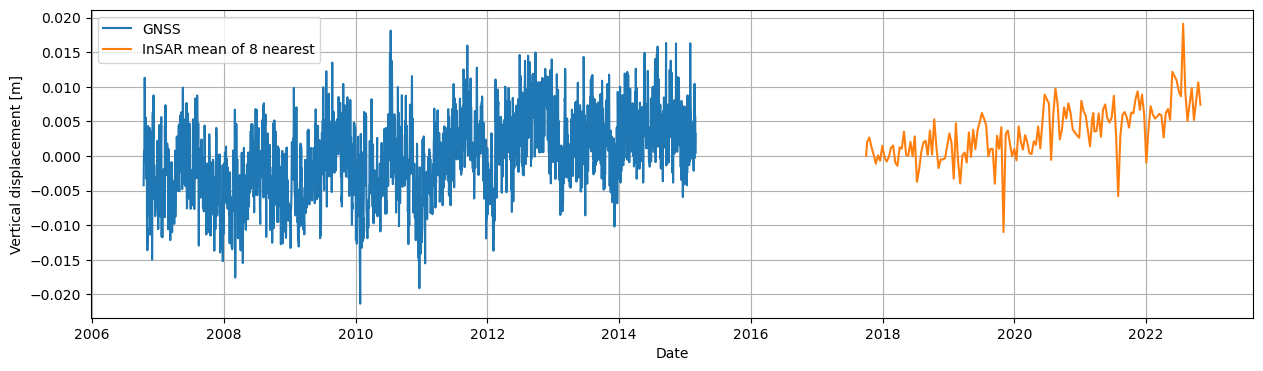

In [17]:
# Convert InSAR mean to numpy aligned with dates
plt.figure(figsize=(15,4))
plt.plot(gnss_dates, gnss_u, label="GNSS")
plt.plot(insar_dates, insar_mean_u, label=f"InSAR mean of {N} nearest")
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.grid(True)
plt.legend()
plt.show()


# Fit linear trend model

Setup time vectors

In [18]:
gnss_t = (gnss_dates - gnss_dates.iloc[0]).dt.days.values
print(gnss_t)

insar_t = (insar_dates - gnss_dates.iloc[0]).days.values
print(insar_t)

t = np.arange(gnss_t[0], insar_t[-1] + 1)
print(t)

dates_full = gnss_dates.iloc[0] + pd.to_timedelta(t, unit='D')


[   0    1    2 ... 3058 3059 3060]
[4006 4012 4024 4036 4048 4060 4072 4084 4096 4108 4120 4132 4144 4156
 4168 4180 4192 4204 4216 4228 4240 4252 4264 4276 4288 4300 4312 4324
 4336 4342 4348 4360 4372 4384 4396 4408 4420 4432 4444 4456 4468 4480
 4492 4504 4516 4528 4540 4552 4564 4576 4588 4600 4612 4624 4636 4648
 4660 4672 4684 4696 4708 4720 4732 4744 4756 4768 4780 4792 4804 4816
 4828 4840 4852 4864 4876 4888 4900 4912 4924 4936 4948 4960 4972 4984
 4996 5020 5032 5044 5056 5068 5080 5092 5104 5116 5128 5140 5152 5164
 5176 5188 5200 5212 5224 5248 5260 5266 5272 5284 5296 5308 5320 5332
 5344 5356 5368 5380 5392 5404 5416 5428 5440 5452 5464 5476 5488 5500
 5512 5524 5536 5548 5560 5572 5584 5596 5608 5620 5632 5644 5656 5668
 5680 5692 5704 5728 5740 5752 5764 5776 5788 5800 5812 5824 5836 5848
 5860]
[   0    1    2 ... 5858 5859 5860]


Fit linear trend to GNSS data

In [19]:
def linear_trend(t, a, b):
    return a + b * t

popt_gnss, pcov_gnss = curve_fit(linear_trend, gnss_t, gnss_u)

a_gnss_hat, b_gnss_hat = popt_gnss
b_std = np.sqrt(pcov_gnss[1, 1])

print(f"Offset a gnss= {a_gnss_hat:.5f} m")
print(f"Velocity gnss= {b_gnss_hat*365.25:.5f} ± {b_std*365.25:.5f} m/year")


popt_insar, pcov_insar = curve_fit(linear_trend, insar_t, insar_mean_u)
a_insar_hat, b_insar_hat = popt_insar
b_insar_std = np.sqrt(pcov_insar[1, 1])
print(f"Offset a_insar = {a_insar_hat:.5f} m")
print(f"Velocity_insar = {b_insar_hat*365.25:.5f} ± {b_insar_std*365.25:.5f} m/year")

# Slope correction factor INSAR to align with GNSS

slope_correction_linear = b_gnss_hat / b_insar_hat
print(f"Slope correction factor: {slope_correction_linear:.5f}")

Offset a gnss= -0.00469 m
Velocity gnss= 0.00111 ± 0.00004 m/year
Offset a_insar = -0.01946 m
Velocity_insar = 0.00169 ± 0.00016 m/year
Slope correction factor: 0.65576


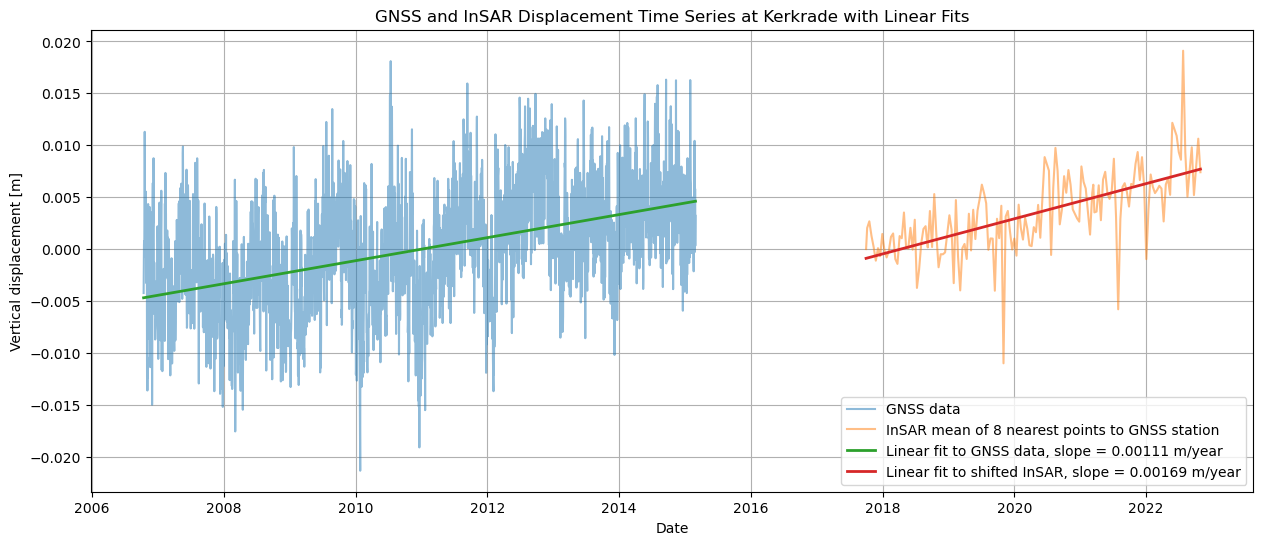

In [20]:
plt.figure(figsize=(15,6))
plt.plot(gnss_dates, gnss_u, label="GNSS data", alpha=0.5)
plt.plot(insar_dates, insar_mean_u, label=f"InSAR mean of {N} nearest points to GNSS station", alpha=0.5)
plt.plot(gnss_dates, linear_trend(gnss_t, *popt_gnss), label=f"Linear fit to GNSS data, slope = {b_gnss_hat*365.25:.5f} m/year", linewidth=2)
plt.plot(insar_dates, linear_trend(insar_t, *popt_insar), label=f"Linear fit to shifted InSAR, slope = {b_insar_hat*365.25:.5f} m/year", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.title(f"GNSS and InSAR Displacement Time Series at {station_name} with Linear Fits")
plt.grid(True)
plt.legend()
plt.show()

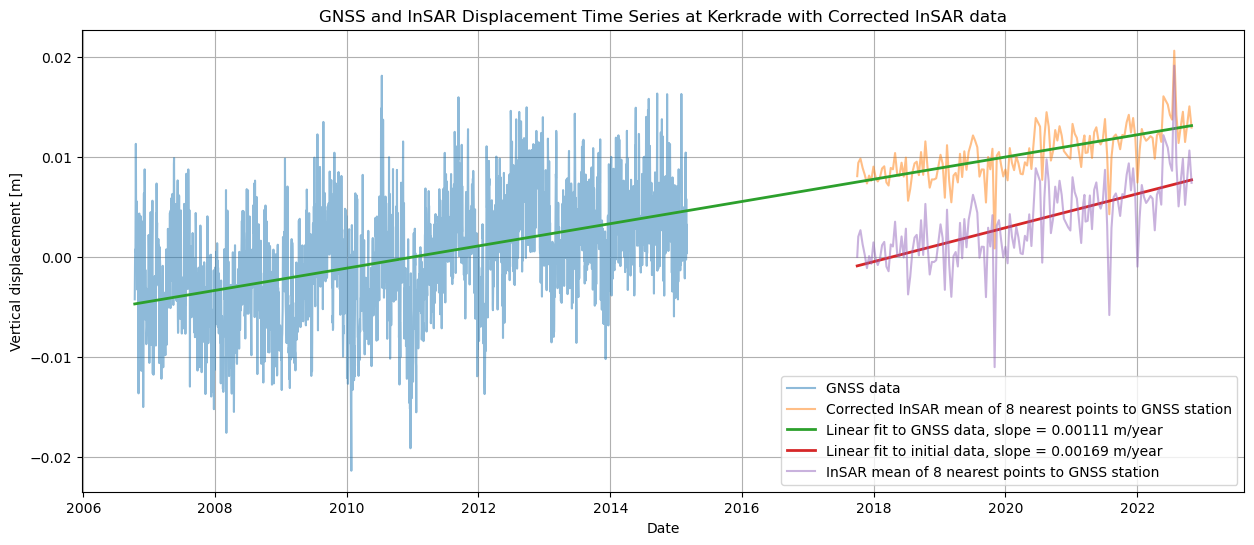

In [21]:
# Correcting the slope and shift  of the InSAR data to match GNSS
insar_mean_u_slope_corrected = insar_mean_u * slope_correction_linear
shift_difference_mean_insar = np.abs(np.mean(linear_trend(insar_t, *popt_gnss) - insar_mean_u_slope_corrected))
insar_mean_u_final = insar_mean_u_slope_corrected + shift_difference_mean_insar
plt.figure(figsize=(15,6))
plt.plot(gnss_dates, gnss_u, label="GNSS data", alpha=0.5)
plt.plot(insar_dates, insar_mean_u_final, label=f"Corrected InSAR mean of {N} nearest points to GNSS station", alpha=0.5)
plt.plot(dates_full, linear_trend(t, *popt_gnss), label=f"Linear fit to GNSS data, slope = {b_gnss_hat*365.25:.5f} m/year", linewidth=2)
plt.plot(insar_dates, linear_trend(insar_t, *popt_insar), label=f"Linear fit to initial data, slope = {b_insar_hat*365.25:.5f} m/year", linewidth=2)
plt.plot(insar_dates, insar_mean_u, label=f"InSAR mean of {N} nearest points to GNSS station", alpha=0.5)
plt.title(f"GNSS and InSAR Displacement Time Series at {station_name} with Corrected InSAR data")
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.grid(True)
plt.legend()
plt.show()



# Fit seasonal model

a_gnss = 2.9994707914518576e-06
b_gnss = -0.004583255760775055
c_gnss = -0.0019716155831540957
d_gnss = 0.0009237249869550779
 
a_insar = 4.513819311571982e-06
b_insar = -0.01887015872868788
c_insar = -0.0007635439085179321
d_insar = 0.0002530298019252568
Slope correction factor: 0.66451


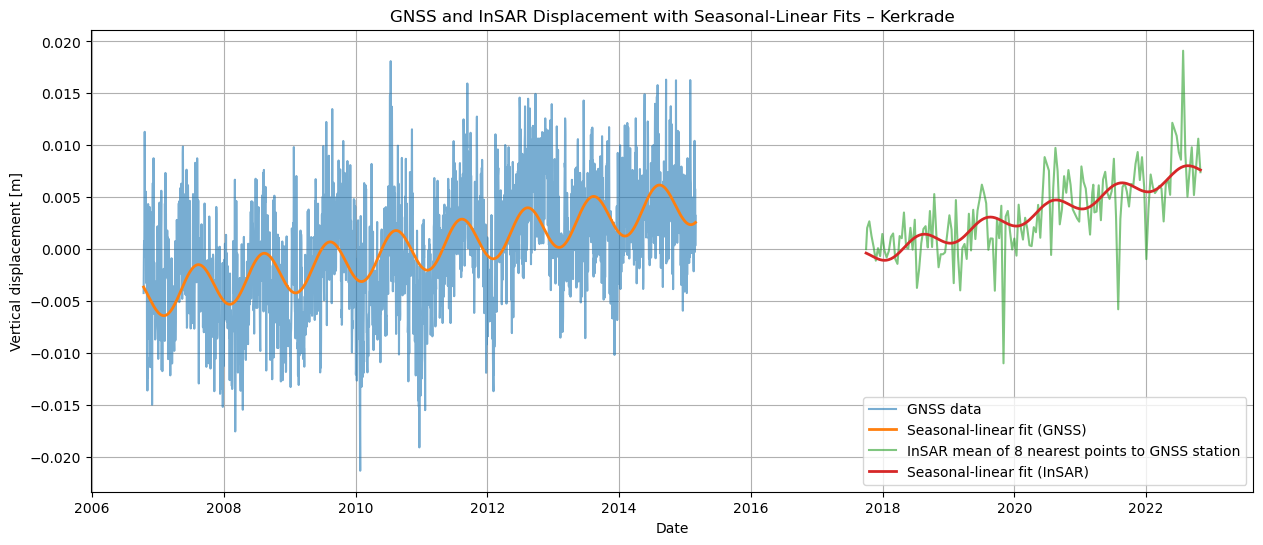

In [22]:
def seasonal_linear_trend(t, a, b, c, d):
     period = 365.25 
     return a * t + b + c * np.sin(2/period * np.pi * t ) + d * np.cos(2/period * np.pi * t)


params_gnss, _ = curve_fit(seasonal_linear_trend, gnss_t, gnss_u)
a_gnss, b_gnss, c_gnss, d_gnss = params_gnss

params_insar, _ = curve_fit(seasonal_linear_trend, insar_t, insar_mean_u)
a_insar, b_insar, c_insar, d_insar = params_insar

print('a_gnss =', a_gnss)
print('b_gnss =', b_gnss)
print('c_gnss =', c_gnss)
print('d_gnss =', d_gnss)
print(' ')
print('a_insar =', a_insar)
print('b_insar =', b_insar)
print('c_insar =', c_insar)
print('d_insar =', d_insar)

slope_correction_seasonal = a_gnss / a_insar
print(f"Slope correction factor: {slope_correction_seasonal:.5f}")


# Plot both datasets and the seasonal curves
plt.figure(figsize=(15, 6))
plt.plot(gnss_dates, gnss_u, label="GNSS data", alpha=0.6, markersize=3)
plt.plot(gnss_dates, seasonal_linear_trend(gnss_t, *params_gnss), label="Seasonal-linear fit (GNSS)", linewidth=2)
plt.plot(insar_dates, insar_mean_u, label=f"InSAR mean of {N} nearest points to GNSS station", alpha=0.6, markersize=3)
plt.plot(insar_dates, seasonal_linear_trend(insar_t, *params_insar), label="Seasonal-linear fit (InSAR)", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.title(f"GNSS and InSAR Displacement with Seasonal-Linear Fits – {station_name}")
plt.legend()
plt.title(f"GNSS and InSAR Displacement with Seasonal-Linear Fits – {station_name}")
plt.grid(True)
plt.show()


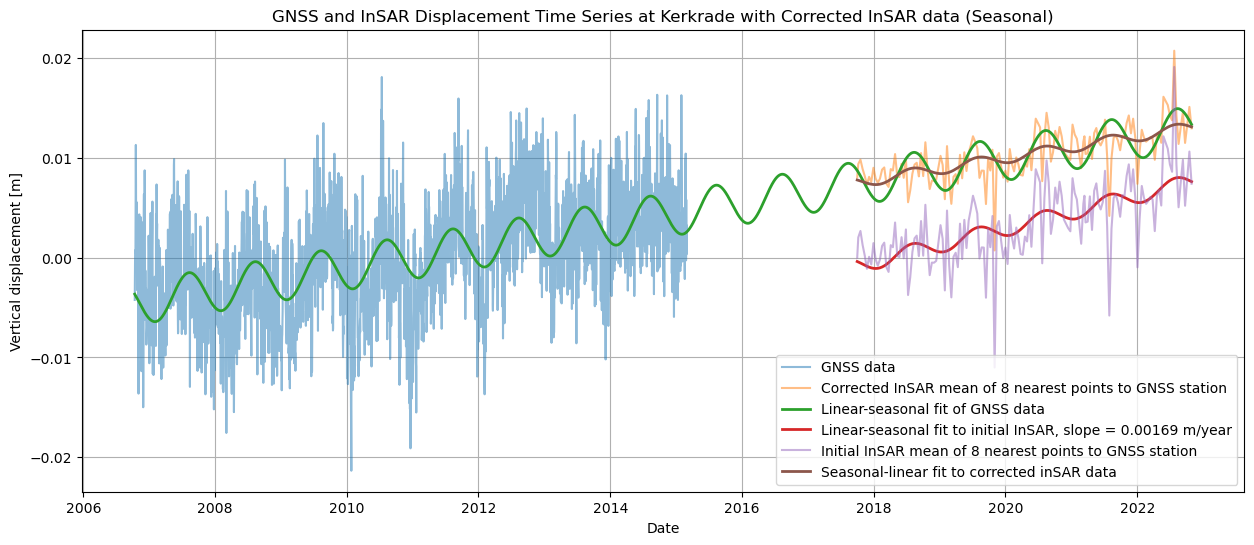

In [23]:
insar_mean_u_slope_corrected_seasonal = insar_mean_u * slope_correction_seasonal
shift_difference_mean_insar_seasonal = np.abs(np.mean(linear_trend(insar_t, *popt_gnss) - insar_mean_u_slope_corrected_seasonal))
insar_mean_u_final_seasonal = insar_mean_u_slope_corrected_seasonal + shift_difference_mean_insar_seasonal

plt.figure(figsize=(15,6))
plt.plot(gnss_dates, gnss_u, label="GNSS data", alpha=0.5)
plt.plot(insar_dates, insar_mean_u_final_seasonal, label=f"Corrected InSAR mean of {N} nearest points to GNSS station", alpha=0.5)
plt.plot(dates_full, seasonal_linear_trend(t, *params_gnss), label="Linear-seasonal fit of GNSS data", linewidth=2)
plt.plot(insar_dates, seasonal_linear_trend(insar_t, *params_insar), label=f"Linear-seasonal fit to initial InSAR, slope = {b_insar_hat*365.25:.5f} m/year", linewidth=2)
plt.plot(insar_dates, insar_mean_u, label=f"Initial InSAR mean of {N} nearest points to GNSS station", alpha=0.5)
plt.plot(insar_dates, seasonal_linear_trend(insar_t, *params_insar)*slope_correction_seasonal+shift_difference_mean_insar_seasonal, 
         label=f"Seasonal-linear fit to corrected inSAR data", linewidth=2)
plt.title(f"GNSS and InSAR Displacement Time Series at {station_name} with Corrected InSAR data (Seasonal)")
plt.xlabel("Date")
plt.ylabel("Vertical displacement [m]")
plt.grid(True)
plt.legend()
plt.show()


# Evalutation of fit

In [24]:
# RMSE Calculation

# Linear fit and seasonal fit to GNSS data
gnss_linear_fit = linear_trend(gnss_t, *popt_gnss)
gnss_seasonal_fit = seasonal_linear_trend(gnss_t, *params_gnss)

# Calculate RMSE for linear fit
rmse_linear_gnss = np.sqrt(np.mean((gnss_u - gnss_linear_fit) ** 2))
print(f"RMSE (Linear Fit): {rmse_linear_gnss:.5f} m")
# Calculate RMSE for seasonal fit
rmse_seasonal_gnss = np.sqrt(np.mean((gnss_u - gnss_seasonal_fit) ** 2))
print(f"RMSE (Seasonal Fit): {rmse_seasonal_gnss:.5f} m")    

# differnce in RMSE %
rmse_diff_percent = ((rmse_linear_gnss - rmse_seasonal_gnss) / rmse_seasonal_gnss) * 100
print(f"The linear RMSE is {rmse_diff_percent:.2f}% larger than the seasonal RMSE.")




RMSE (Linear Fit): 0.00486 m
RMSE (Seasonal Fit): 0.00461 m
The linear RMSE is 5.42% larger than the seasonal RMSE.


In [25]:
# RMSE Calculation

# Linear fit and seasonal-linear fit to inSAR data
insar_linear_fit = linear_trend(insar_t, *popt_insar)
insar_seasonal_fit = seasonal_linear_trend(insar_t, *params_insar)

# Calculate RMSE for linear fit
rmse_linear_insar = np.sqrt(np.mean((insar_mean_u - insar_linear_fit) ** 2))
print(f"RMSE InSAR (Linear Fit): {rmse_linear_insar:.5f} m")
# Calculate RMSE for seasonal fit
rmse_seasonal_insar = np.sqrt(np.mean((insar_mean_u - insar_seasonal_fit) ** 2))
print(f"RMSE InSAR (Seasonal Fit): {rmse_seasonal_insar:.5f} m")       

# differnce in RMSE %
rmse_diff_percent_insar = ((rmse_linear_insar - rmse_seasonal_insar) / rmse_seasonal_insar) * 100
print(f"The linear InSAR RMSE is {rmse_diff_percent_insar:.2f}% larger than the seasonal InSAR RMSE.")


RMSE InSAR (Linear Fit): 0.00284 m
RMSE InSAR (Seasonal Fit): 0.00279 m
The linear InSAR RMSE is 1.99% larger than the seasonal InSAR RMSE.


Multiplication of the whole inSAR data set with the slope correction factor found in the linear fit to align with GNSS data

In [27]:
# Multiply all u_20* columns by slope_correction_linear
u_cols = insar_asc_u.filter(regex=r"^u_20").columns
insar_asc_u[u_cols] = insar_asc_u[u_cols] * slope_correction_linear

# File still in gitignore, so run locally to save the file
insar_asc_u.to_csv('insar/sentinel1_asc_t088_limburg_corrected.csv', index=False)

# Ideas to continue

- Check the sign of the InSAR data
- Take the distance from the station into account in weighted technique
- Linear or model fit to the GNSS data
  - Constant model: $u_{GNSS} \approx u_{InSAR} + c$ and estimate c as the median of differences
  - Linear trend model: $u_{GNSS} \approx a + bt + u_{InSAR}$
  - Seasonal model : $u_{GNSS} \approx a + bt + Asin(2pit) + Bcos(2pit) + \epsilon$ then evaluate model at InSAR dates and estimate only on offset
- Data does not overlap
  - Option 1: Use the trend of the GNSS but is risky but OK for this assignment
  - Option 2: Make use of other GNSS stations that do have overlap



Assignment overall:
Part 1: Data integration
- Conversion of InSAR LOS to 'u'
- Datum alignment of the InSAR points using GNSS (working on this now)

Part 2: Anomaly detection
- Time-series modelling to get the acceleration
- Define anomalies
- Find anomalies